In [1]:
# Determine if this is a benchmarking run
try:
    __benchmark__
except NameError:
    __benchmark__ = False

# Spotted star

This is a simple example of how one might go about modeling rotational light curves of spotted stars.

In [2]:
import starry
import numpy as np
import matplotlib.pyplot as pl
from tqdm import tqdm

In [3]:
%matplotlib inline

## Creating a map with a starspot

Let's create a 30th order map with a starspot at latitude 30$^\circ$ N and longitude 30$^\circ$ E:

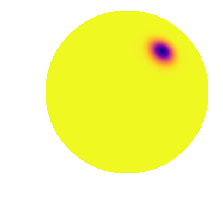

In [4]:
star = starry.Map(30)
star[0,0] = 1
star.add_gaussian(sigma=0.1, amp=-1, lat=30, lon=30)
star.show()

We can add additional spots to the map if we'd like:

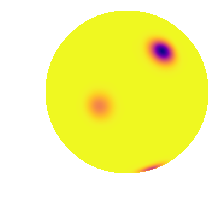

In [5]:
star.add_gaussian(sigma=0.1, amp=-0.3, lat=-10, lon=-20)
star.add_gaussian(sigma=0.1, amp=-0.5, lat=-70, lon=60)
star.show()

If stars didn't rotate differentially, computing this star's rotational light curve would be cake. Let's give it a rotation period of 1 day and see what it looks like:

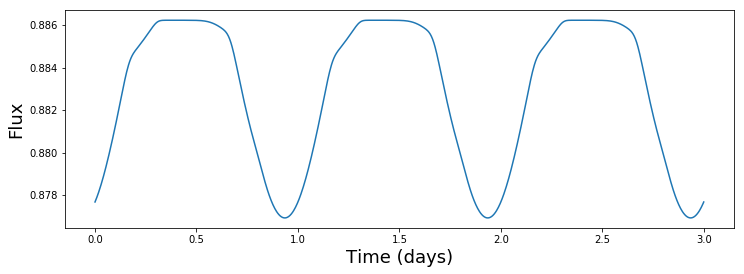

In [6]:
time = np.linspace(0, 3, 1000)
P = 1.
theta = 360 / P * time
flux = star.flux(axis=(0, 1, 0), theta=theta)
fig, ax = pl.subplots(1, figsize=(12, 4))
pl.plot(time, flux)
pl.xlabel('Time (days)', fontsize=18);
pl.ylabel('Flux', fontsize=18);

In [7]:
if __benchmark__:
    assert np.allclose(flux[::200], np.array([0.87767265, 0.88599279, 0.88483153, 0.87988858, 0.88622685]))

## Differential rotation

In reality, starspots at different latitudes should rotate at different rates. We can simulate this by generating different `starry` maps for each starspot, and adding the light curves together.

Let's generate a few spots of random sizes, amplitudes, and location on the star.

In [8]:
nspots = 5
sigma = [0.1, 0.1, 0.2, 0.3, 0.1]
amp = [-0.1, -0.2, -0.01, -0.05, -0.1]
lat = np.array([0, 30, -20, 45, -60])
lon = np.array([30, 60, 120, -30, -45])
spot = [starry.Map(30) for n in range(nspots)]
for n in range(nspots):
    spot[n].add_gaussian(sigma=sigma[n], amp=amp[n], lat=lat[n], lon=lon[n])

We can visualize what the star looks like at time $t = 0$ by adding the maps:

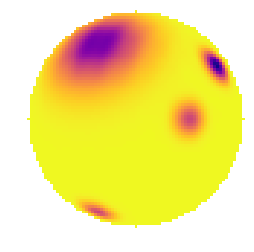

In [9]:
x, y = np.meshgrid(np.linspace(-1, 1, 75), np.linspace(-1, 1, 75))
img = np.zeros_like(x)
for n in range(nspots):
    img += np.array([spot[n].evaluate(x=x[j], y=y[j]) for j in range(75)])
pl.imshow(img, cmap='plasma', origin='lower');
pl.gca().axis('off');

That's a crazy looking star. For simplicity, let's give each of the spots a rotation period proportional to the latitude:

In [10]:
P = 1 + np.abs(lat * np.pi / 180)
print(P)

[1.         1.52359878 1.34906585 1.78539816 2.04719755]


Let's compute the light curve over the span of 10 days:

100%|██████████| 16/16 [00:01<00:00,  8.94it/s]


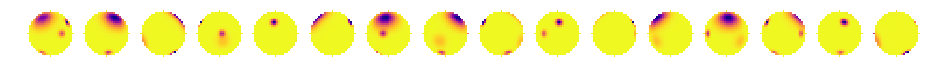

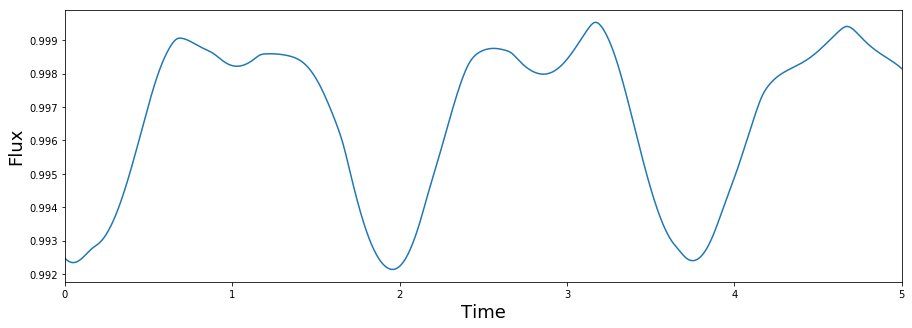

In [11]:
# The angular position of the spots over time
time = np.linspace(0, 5, 1000)
theta = [360 / P[n] * time for n in range(nspots)]

# Plot the map
nimg = 16
res = 25
fig, ax = pl.subplots(1, nimg, figsize=(nimg, 1))
x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
for k, i in tqdm(enumerate(np.linspace(0, 1000, nimg, endpoint=False)), total=16):
    img = np.zeros_like(x)
    for n in range(nspots):
        img += np.array([spot[n].evaluate(theta=theta[n][int(i)], x=x[j], y=y[j]) for j in range(res)])
    img -= np.nanmin(img)
    img /= np.nanmax(img)
    ax[k].imshow(img, cmap='plasma', origin='lower', vmax=1., vmin=0.);
    ax[k].axis('off');

# Plot the combined light curve
lc = 1 + np.sum([spot[n].flux(axis=(0,1,0), theta=theta[n]) for n in range(nspots)], axis=0)
fig, ax = pl.subplots(1, figsize=(15, 5))
ax.plot(time, lc);
ax.set_xlim(0,5)
ax.set_ylabel("Flux", fontsize=18);
ax.set_xlabel("Time", fontsize=18);

In [12]:
if __benchmark__:
    assert np.allclose(lc[::200], np.array([0.99248011, 0.99823553, 0.99224473, 0.99844553, 0.99494004]))

## Transits of spots

In general, computing spot occultations is not something you typically want to use `starry` for, since there are better tools out there for this very thing. The problem is that to get a good, localized spot model, you need to go to pretty high degree in the spherical harmonics; note how we've been using $l = 30$ for the rotational light curves above, which is **quite** high! The reason we were able to get away with it is that the computation of rotational light curves is very numerically stable (although it does break down eventually! I wouldn't push it too far past 30). It's also fast, since it requires no recursions or evaluations of elliptic integrals.

For transits, it's a different story. The occultation equations used in `starry` become numerically unstable at much lower spherical harmonic degree. Let's reduce the degree of the map by copying the coefficients of `spot[3]` (the really big one) over to a second map of degree $l_{max} = 10$:

In [13]:
lmax = 10
star = starry.Map(lmax)
for l in range(lmax + 1):
    for m in range(-l, l + 1):
        star[l, m] = spot[3][l, m]

Here's what the new map looks like (it's actually not that bad):

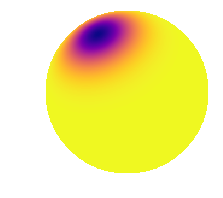

In [14]:
star.show()

Now let's compute the transit light curve of a planet with $r = 0.1$ transiting along the $x$ axis at $y = 0.9$ (right through the middle of the spot:

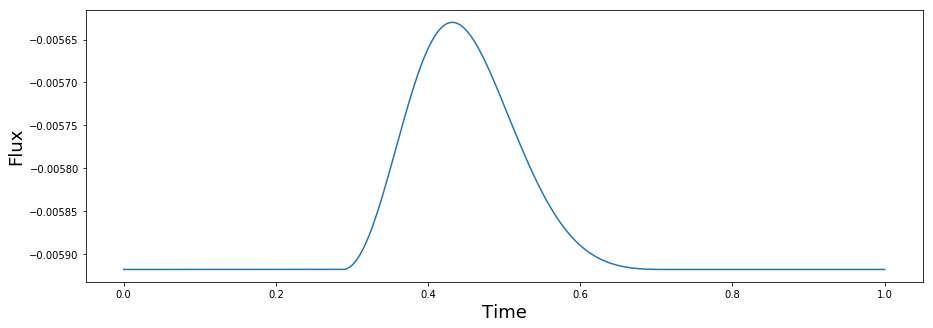

In [15]:
fig, ax = pl.subplots(1, figsize=(15, 5))
pl.plot(np.linspace(0, 1, 1000), star.flux(ro=0.1, xo=np.linspace(-1.5, 1.5, 1000), yo=0.9));
pl.ylabel("Flux", fontsize=18);
pl.xlabel("Time", fontsize=18);

That doesn't look right! It turns out that we never set a baseline for our map when we created it a while back: we simply added a gaussian with negative amplitude, which means the spot actually has *negative* flux. We can verify this by computing the map minimum:

In [16]:
star.minimum()

-0.018615812552751854

Let's add a little bit of power to the $l = 0, m = 0$ harmonic so that the mean stellar flux is positive:

In [17]:
star[0, 0] = 0.1
star.minimum()

0.010437576543005006

Finally, let's re-compute the transit light curve. For reference, let's also compute the light curve of a star without the spot:

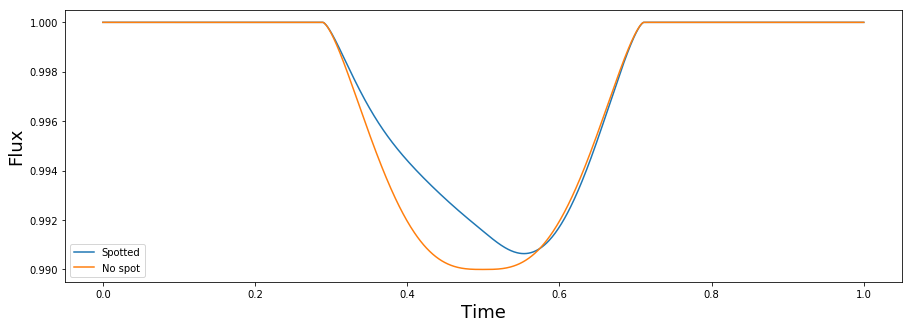

In [18]:
# Flux w/ spot
flux_spot = star.flux(ro=0.1, xo=np.linspace(-1.5,1.5,1000), yo=0.9)
flux_spot /= flux_spot[0]

# Flux w/ no spot
star_nospot = starry.Map(lmax)
star_nospot[0, 0] = 0.1
flux_nospot = star_nospot.flux(ro=0.1, xo=np.linspace(-1.5, 1.5, 1000), yo=0.9)
flux_nospot /= flux_nospot[0]

fig, ax = pl.subplots(1, figsize=(15, 5))
pl.plot(np.linspace(0, 1, 1000), flux_spot, label='Spotted');
pl.plot(np.linspace(0, 1, 1000), flux_nospot, label='No spot');
pl.legend(loc='lower left');
pl.ylabel("Flux", fontsize=18);
pl.xlabel("Time", fontsize=18);

In [19]:
if __benchmark__:
    assert np.allclose((flux_spot - flux_nospot)[::50][5:-5], 
                        np.array([ 0.00000000e+00,  2.88929108e-05,  1.06178254e-03,  2.46380291e-03,
                                   2.58400772e-03,  1.52724297e-03,  3.65264303e-04, -2.34168836e-04,
                                   -2.55883105e-04, -2.71610702e-05]))

Now we're talking! 

Lastly, just for fun, we can compute the transit light curve for the multi-spotted star from before. Let's sum up the maps for all the spots and feed them into a tenth order map, just like before:

In [20]:
y = np.sum([spot[n].y for n in range(nspots)], axis=0)

In [21]:
lmax = 10
star = starry.Map(10)
n = 0
for l in range(lmax + 1):
    for m in range(-l, l + 1):
        star[l,m] = y[n]
        n += 1
star[0,0] = 0.2

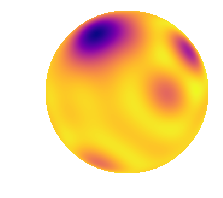

In [22]:
star.show()

Looks good. Let's change the transit parameters slightly to get a prettier light curve:

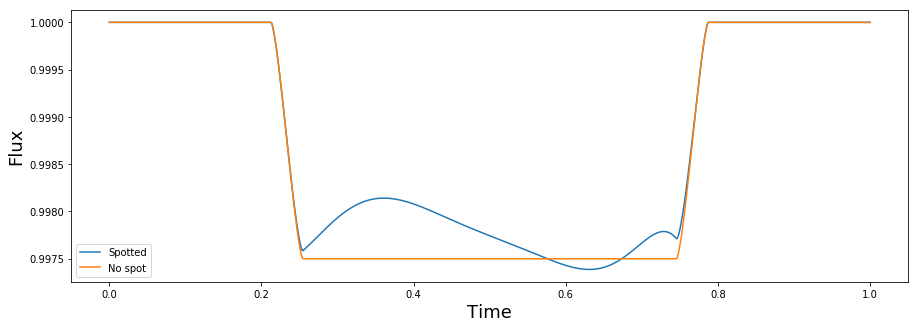

In [23]:
# Flux w/ spot
flux_spot = star.flux(ro=0.05, xo=np.linspace(-1.5,1.5,1000), yo=0.6)
flux_spot /= flux_spot[0]

# Flux w/ no spot
star_nospot = starry.Map(lmax)
star_nospot[0, 0] = 0.1
flux_nospot = star_nospot.flux(ro=0.05, xo=np.linspace(-1.5, 1.5, 1000), yo=0.6)
flux_nospot /= flux_nospot[0]

fig, ax = pl.subplots(1, figsize=(15, 5))
pl.plot(np.linspace(0, 1, 1000), flux_spot, label='Spotted');
pl.plot(np.linspace(0, 1, 1000), flux_nospot, label='No spot');
pl.legend(loc='lower left');
pl.ylabel("Flux", fontsize=18);
pl.xlabel("Time", fontsize=18);

Two spot crossings are clearly visible!

In [24]:
if __benchmark__:
    assert np.allclose((flux_spot - flux_nospot)[::50][5:-5], 
                        np.array([ 5.77140208e-05,  4.35765769e-04,  6.35833816e-04,  5.78314265e-04,
                                   4.08982471e-04,  2.42047812e-04,  8.27582118e-05, -7.16763692e-05,
                                   -8.94556801e-05,  1.71920494e-04,]))